# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [10]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 120000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (120000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [12]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [13]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [14]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [17]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(103932, 10)

In [18]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.61

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [19]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [21]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(103930, 10)


1    87254
0    16676
Name: Score, dtype: int64

In [0]:
Score=final['Score']

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [23]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I really enjoy the flavor of these torrincini.  But be aware, that 1/3 of the package is the traditional 'hard' torrone.  And when they say hard, they mean it.  I'm not a big fan of the hard variety, but their soft and chocolate versions are extremely tasty.
This is a great vanilla and I always use it when I'm baking something with more expensive ingredients or that I'm serving to people.  I don't waste this on my smoothies, etc - for that, I use the medium priced vanilla.
The actual product deserves 5 stars, the reason I gave it 4 stars is because its like three dollars at asianfoodgrocer.com. That's where I order it from, not amazon. Much lower prices.


In [24]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [25]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I really enjoy the flavor of these torrincini.  But be aware, that 1/3 of the package is the traditional 'hard' torrone.  And when they say hard, they mean it.  I'm not a big fan of the hard variety, but their soft and chocolate versions are extremely tasty.
This is a great vanilla and I always use it when I'm baking something with more expensive ingredients or that I'm serving to people.  I don't waste this on my smoothies, etc - for that, I use the medium priced vanilla.
The actual product deserves 5 stars, the reason I gave it 4 stars is because its like three dollars at asianfoodgrocer.com. That's where I order it from, not amazon. Much lower prices.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great vanilla and I always use it when I am baking something with more expensive ingredients or that I am serving to people.  I do not waste this on my smoothies, etc - for that, I use the medium priced vanilla.


In [28]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [29]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great vanilla and I always use it when I am baking something with more expensive ingredients or that I am serving to people I do not waste this on my smoothies etc for that I use the medium priced vanilla 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [31]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 103930/103930 [00:51<00:00, 2006.72it/s]


In [32]:
preprocessed_reviews[1500]

'great vanilla always use baking something expensive ingredients serving people not waste smoothies etc use medium priced vanilla'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [33]:
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 103930/103930 [00:51<00:00, 2024.59it/s]


# [4] Featurization

In [34]:
preprocessed_reviews=np.array(preprocessed_reviews)
preprocessed_summary=np.array(preprocessed_summary)
x_train=[]
x_test=[]
for i in range(int((preprocessed_reviews.shape[0]*0.7))+1):
    x_train.append(preprocessed_reviews[i]+" "+preprocessed_summary[i])
for i in range(int((preprocessed_reviews.shape[0]*0.7))+1,preprocessed_reviews.shape[0]):
    x_test.append(preprocessed_reviews[i]+" "+preprocessed_summary[i])
y_train=Score[:int((Score.shape[0]*0.7))+1]
y_test=Score[int((Score.shape[0]*0.7))+1:]
print(len(x_train))
print(len(x_test))
print(y_train.shape)
print(y_test.shape)

72752
31178
(72752,)
(31178,)


## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts_train=count_vect.fit_transform(x_train)
final_counts_test=count_vect.transform(x_test)

## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=30)
final_tfidf_train=tf_idf_vect.fit_transform(x_train)
final_tfidf_test=tf_idf_vect.transform(x_test)

## [4.4] Word2Vec

In [37]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())

100%|██████████| 72752/72752 [00:00<00:00, 114292.82it/s]


In [38]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance[:int((preprocessed_reviews.shape[0]*0.7))+1],min_count=5,size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.7910217046737671), ('excellent', 0.7828258872032166), ('awesome', 0.7689943313598633), ('terrific', 0.7219368815422058), ('wonderful', 0.710106611251831), ('good', 0.6983031630516052), ('amazing', 0.6350631713867188), ('nice', 0.6140375733375549), ('fabulous', 0.5843562483787537), ('perfect', 0.5738462209701538)]
[('tastiest', 0.6948974132537842), ('coolest', 0.6530125141143799), ('greatest', 0.6486254930496216), ('nastiest', 0.6347446441650391), ('disgusting', 0.6285277009010315), ('best', 0.6195342540740967), ('nicest', 0.6184190511703491), ('horrible', 0.605605959892273), ('awful', 0.5885617733001709), ('experienced', 0.5751122236251831)]


In [39]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16513
sample words  ['dogs', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'made', 'china', 'satisfied', 'safe', 'dog', 'lover', 'loves', 'chicken', 'product', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'bought', 'local', 'hardware', 'terrible', 'fly', 'problem', 'trapped', 'year', 'still', 'hanging', 'buy', 'caught', 'many', 'flies', 'house', 'weeks']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [40]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 72752/72752 [02:51<00:00, 425.29it/s]

72752
100


In [41]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 31178/31178 [01:19<00:00, 394.53it/s]

31178
100


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [43]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 72752/72752 [34:42<00:00, 26.54it/s]


In [44]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 31178/31178 [15:40<00:00, 33.14it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
my_cv = TimeSeriesSplit(n_splits=10)
param_grid= {"max_depth":[1, 5, 10, 50, 100, 500, 1000], "min_samples_split":[5, 10, 100, 500]}

In [0]:
grid=GridSearchCV(DecisionTreeClassifier(), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)

In [47]:
%time grid.fit(final_counts_train,y_train)

CPU times: user 21.5 s, sys: 896 ms, total: 22.4 s
Wall time: 39min 19s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### Test data 

Accuracy for depth: 50 ,and sample split: 500
86.69895439091667
[[ 2751  2551]
 [ 1596 24280]]


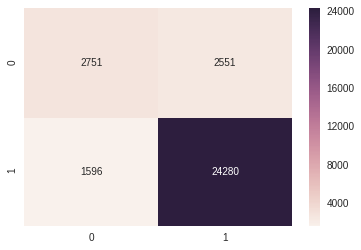

In [48]:
from sklearn.metrics import accuracy_score
optimal_param=grid.best_params_ 
pre=grid.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',and sample split:',optimal_param['min_samples_split'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

###### Train data

Accuracy for depth: 50 ,and sample split: 500
90.38789311634045
[[ 6723  4651]
 [ 2342 59036]]


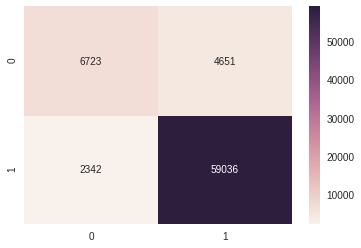

In [49]:
from sklearn.metrics import accuracy_score
optimal_param=grid.best_params_ 
train_pre=grid.predict(final_counts_train)
acc = accuracy_score(y_train,train_pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',and sample split:',optimal_param['min_samples_split'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

###### Test data

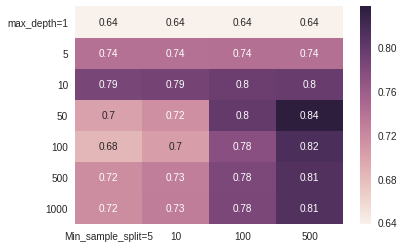

In [56]:
cv_scores=grid.cv_results_ ['mean_test_score']
cv_scores = np.array(cv_scores).reshape(7,4)
cv_scores=pd.DataFrame(cv_scores,index=["max_depth=1","5","10","50","100","500","1000"],columns=["Min_sample_split=5","10","100", "500"])
ax = sns.heatmap(cv_scores,annot=True)

###### Train data

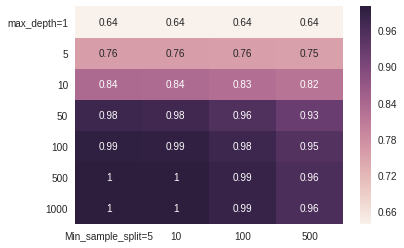

In [59]:
train_scores=grid.cv_results_['mean_train_score']
train_scores=np.array(train_scores).reshape(7,4)
train_scores=pd.DataFrame(train_scores,index=["max_depth=1","5","10","50","100","500","1000"],columns=["Min_sample_split=5","10","100", "500"])
ax = sns.heatmap(train_scores,annot=True)

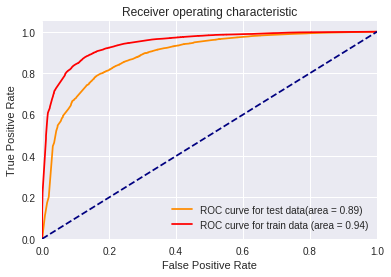

In [60]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_counts_train,y_train)
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [61]:
print(np.take(count_vect.get_feature_names(),np.argsort(-grid.best_estimator_.feature_importances_)[:20]))

['not' 'great' 'disappointed' 'best' 'worst' 'delicious' 'good' 'awful'
 'love' 'terrible' 'loves' 'bad' 'excellent' 'horrible' 'perfect'
 'disappointing' 'nice' 'money' 'favorite' 'tasty']


(-0.5, 399.5, 199.5, -0.5)

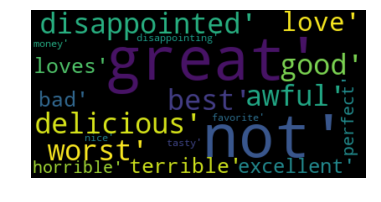

In [62]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(count_vect.get_feature_names(),np.argsort(-grid.best_estimator_.feature_importances_)[:20])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

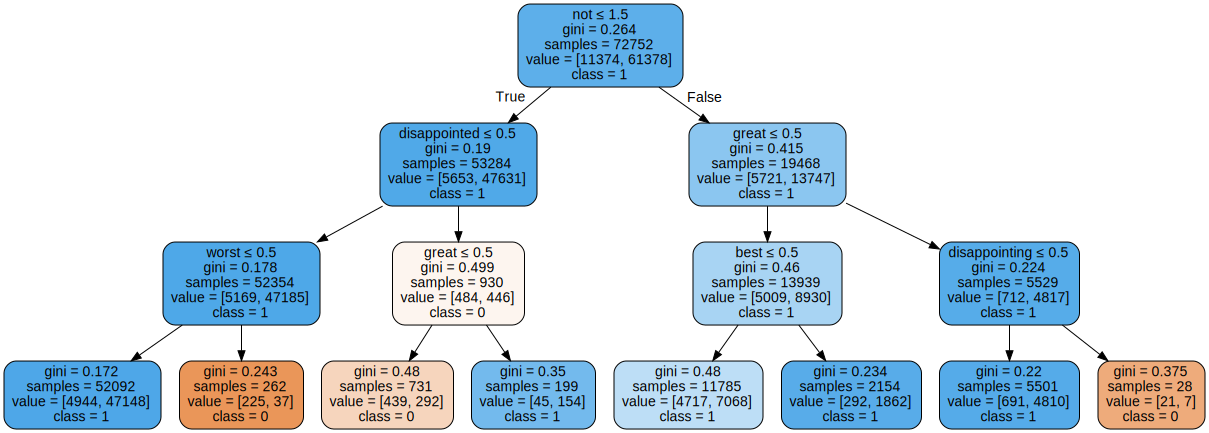

In [63]:
# Please write all the code with proper documentation
from sklearn import tree
clf=DecisionTreeClassifier(max_depth=3,min_samples_split= optimal_param['min_samples_split'])
clf.fit(final_counts_train,y_train)
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=count_vect.get_feature_names(),class_names=np.array(["0","1"]),filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [64]:
# Please write all the code with proper documentation
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 32.4 s, sys: 1.28 s, total: 33.7 s
Wall time: 48min 13s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### Test data

Accuracy for depth: 50 ,and sample split: 500
87.15440374623131
[[ 3071  2231]
 [ 1774 24102]]


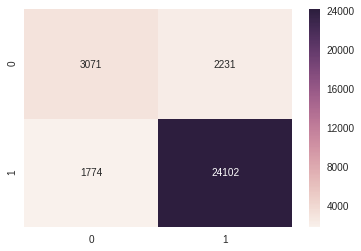

In [65]:
from sklearn.metrics import accuracy_score
optimal_param=grid.best_params_ 
pre=grid.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',and sample split:',optimal_param['min_samples_split'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

###### Train data

Accuracy for depth: 50 ,and sample split: 500
91.28546294259951
[[ 7723  3651]
 [ 2689 58689]]


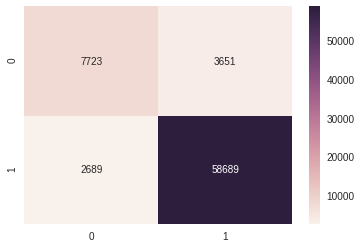

In [66]:
from sklearn.metrics import accuracy_score
optimal_param=grid.best_params_ 
train_pre=grid.predict(final_tfidf_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',and sample split:',optimal_param['min_samples_split'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

###### Test data

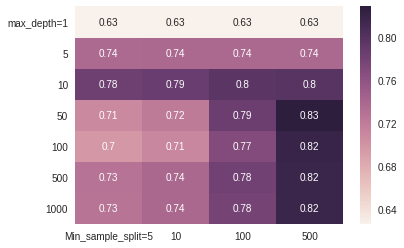

In [67]:
cv_scores=grid.cv_results_ ['mean_test_score']
cv_scores = np.array(cv_scores).reshape(7,4)
cv_scores=pd.DataFrame(cv_scores,index=["max_depth=1","5","10","50","100","500","1000"],columns=["Min_sample_split=5","10","100", "500"])
ax = sns.heatmap(cv_scores,annot=True)

###### train data

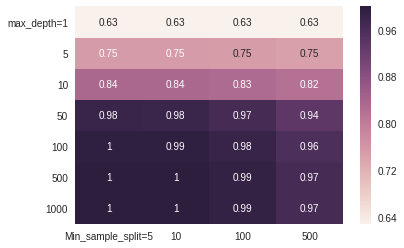

In [68]:
train_scores=grid.cv_results_['mean_train_score']
train_scores=np.array(train_scores).reshape(7,4)
train_scores=pd.DataFrame(train_scores,index=["max_depth=1","5","10","50","100","500","1000"],columns=["Min_sample_split=5","10","100", "500"])
ax = sns.heatmap(train_scores,annot=True)

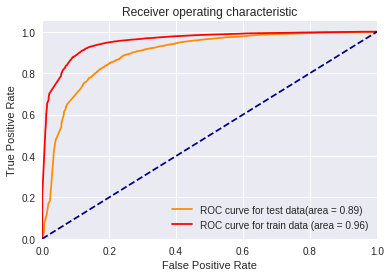

In [69]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train)
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [70]:
# Please write all the code with proper documentation
print(np.take(tf_idf_vect.get_feature_names(),np.argsort(-grid.best_estimator_.feature_importances_)[:20]))

['not' 'great' 'disappointed' 'worst' 'best' 'delicious' 'awful' 'good'
 'bad' 'love' 'not buy' 'not good' 'horrible' 'disappointing' 'money'
 'loves' 'beware' 'terrible' 'not disappointed' 'perfect']


(-0.5, 399.5, 199.5, -0.5)

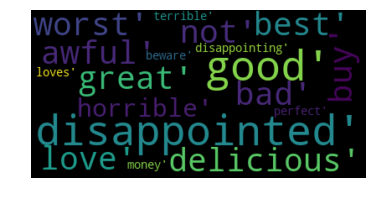

In [71]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(tf_idf_vect.get_feature_names(),np.argsort(-grid.best_estimator_.feature_importances_)[:20])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

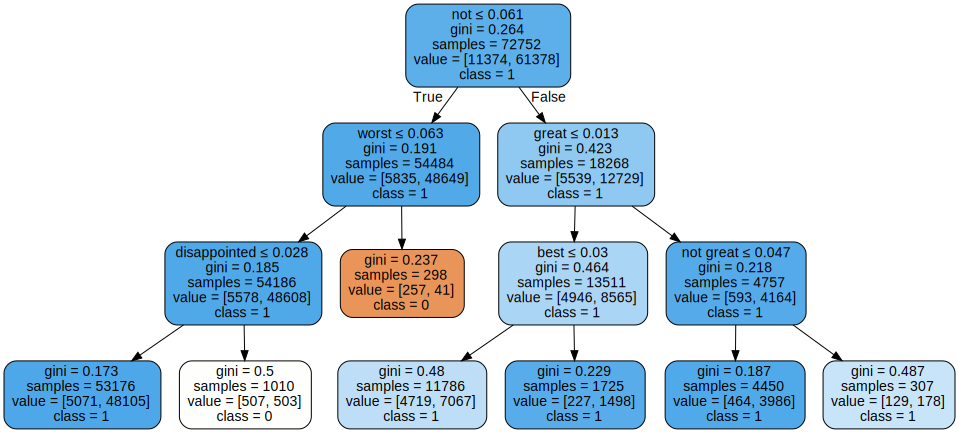

In [72]:
# Please write all the code with proper documentation
from sklearn import tree
clf=DecisionTreeClassifier(max_depth=3,min_samples_split= optimal_param['min_samples_split'])
clf.fit(final_tfidf_train,y_train)
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=tf_idf_vect.get_feature_names(),class_names=np.array(["0","1"]),filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [73]:
# Please write all the code with proper documentation
grid=GridSearchCV(DecisionTreeClassifier(), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 14min 52s, sys: 29.7 s, total: 15min 22s
Wall time: 29min 41s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### Test data

Accuracy for depth: 10 ,and sample split: 500
86.30444544229906
[[ 2181  3121]
 [ 1149 24727]]


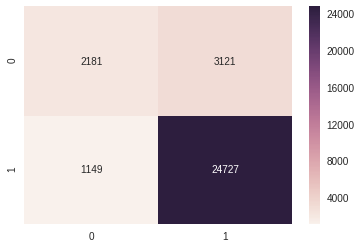

In [74]:
from sklearn.metrics import accuracy_score
optimal_param=grid.best_params_ 
pre=grid.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',and sample split:',optimal_param['min_samples_split'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

###### Train data

Accuracy for depth: 10 ,and sample split: 500
88.38519903232901
[[ 5083  6291]
 [ 2159 59219]]


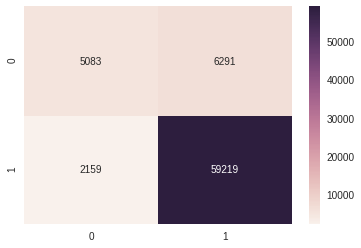

In [75]:
from sklearn.metrics import accuracy_score
optimal_param=grid.best_params_ 
train_pre=grid.predict(sent_vectors_train)
acc = accuracy_score(y_train,train_pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',and sample split:',optimal_param['min_samples_split'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

###### Test data

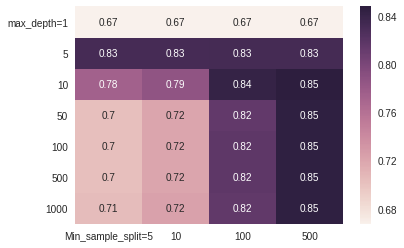

In [76]:
cv_scores=grid.cv_results_ ['mean_test_score']
cv_scores = np.array(cv_scores).reshape(7,4)
cv_scores=pd.DataFrame(cv_scores,index=["max_depth=1","5","10","50","100","500","1000"],columns=["Min_sample_split=5","10","100", "500"])
ax = sns.heatmap(cv_scores,annot=True)

###### Train  data

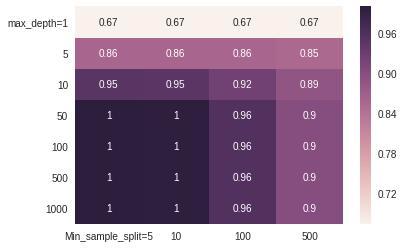

In [77]:
train_scores=grid.cv_results_['mean_train_score']
train_scores=np.array(train_scores).reshape(7,4)
train_scores=pd.DataFrame(train_scores,index=["max_depth=1","5","10","50","100","500","1000"],columns=["Min_sample_split=5","10","100", "500"])
ax = sns.heatmap(train_scores,annot=True)

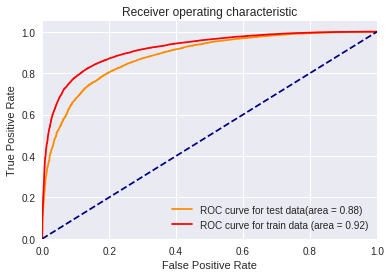

In [78]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [79]:
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 14min 52s, sys: 36.5 s, total: 15min 28s
Wall time: 29min 41s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### Test data

Accuracy for depth: 10 ,and sample split: 500
85.45127974854064
[[ 1876  3426]
 [ 1110 24766]]


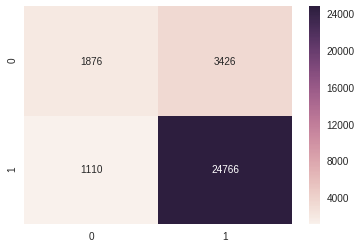

In [80]:
from sklearn.metrics import accuracy_score
optimal_param=grid.best_params_ 
pre=grid.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',and sample split:',optimal_param['min_samples_split'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

###### Train data

Accuracy for depth: 10 ,and sample split: 500
87.62095887398284
[[ 4363  7011]
 [ 1995 59383]]


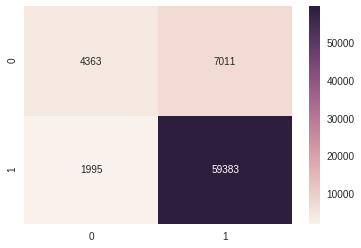

In [81]:
from sklearn.metrics import accuracy_score
optimal_param=grid.best_params_ 
train_pre=grid.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',and sample split:',optimal_param['min_samples_split'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

###### Test data

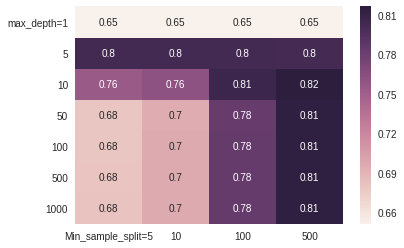

In [82]:
cv_scores=grid.cv_results_ ['mean_test_score']
cv_scores = np.array(cv_scores).reshape(7,4)
cv_scores=pd.DataFrame(cv_scores,index=["max_depth=1","5","10","50","100","500","1000"],columns=["Min_sample_split=5","10","100", "500"])
ax = sns.heatmap(cv_scores,annot=True)

###### Train data

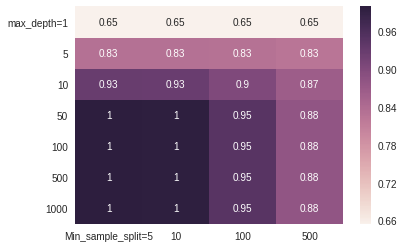

In [83]:
train_scores=grid.cv_results_['mean_train_score']
train_scores=np.array(train_scores).reshape(7,4)
train_scores=pd.DataFrame(train_scores,index=["max_depth=1","5","10","50","100","500","1000"],columns=["Min_sample_split=5","10","100", "500"])
ax = sns.heatmap(train_scores,annot=True)

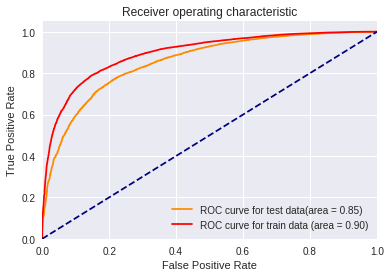

In [84]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# [6] Conclusions

In [1]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
table= PrettyTable()
table.field_names = ["Vectorizer","Model","depth","min sample split","Accuracy","AUC"]
table.add_row(["Bow","Decision Tree",50,500,86.698,0.89])
table.add_row(["Tfidf","Decision Tree",50,500,87.154,0.89])
table.add_row(["Avg-W2v","Decision Tree",10,500,86.304,0.88])
table.add_row(["Tfidf-W2v","Decision Tree",10,500,85.451,0.85])

In [2]:
print(table)

+------------+---------------+-------+------------------+----------+------+
| Vectorizer |     Model     | depth | min sample split | Accuracy | AUC  |
+------------+---------------+-------+------------------+----------+------+
|    Bow     | Decision Tree |   50  |       500        |  86.698  | 0.89 |
|   Tfidf    | Decision Tree |   50  |       500        |  87.154  | 0.89 |
|  Avg-W2v   | Decision Tree |   10  |       500        |  86.304  | 0.88 |
| Tfidf-W2v  | Decision Tree |   10  |       500        |  85.451  | 0.85 |
+------------+---------------+-------+------------------+----------+------+


It can be understood from the above table that Decision tree with Tfidf vectorization with max depth of 50 and min sample split of 500 have the highest AUC score and Accuracy, compared to the other vectorizations 